import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Linear Regresssion Implementation

In [3]:
class LinearRegressionGD:
    def __init__(self, eta=0.01, n_epochs = 100, random_state=1):
        self.eta = eta
        self.n_epochs = n_epochs
        self.random_state = random_state

    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        return self.net_input(X)

    def fit(self, X, Y):
        # 1) intialize the weights and bias
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.array([0.])

        # keeping track of the cost function value in each epoch
        self.costs_ = []

        #repeat for n_epochs
        for i in range(self.n_epochs):
            Y_hat = self.net_input(X)
            errors = (Y_hat - Y)
            self.costs_.append((errors**2).mean())
            
            dw = X.T.dot(errors)/X.shape[0]
            self.w_ -= self.eta * dw
            
            db = np.sum(errors)/X.shape[0]
            self.b_ -= self.eta * db
            
        return self

# Exploring the Ames Housing dataset

- Dataset source: http://jse.amstat.org/v19n3/decock/AmesHousing.txt
- Dataset documentation: http://jse.amstat.org/v19n3/decock/DataDocumentation.txt
- Dataset write-up: http://jse.amstat.org/v19n3/decock.pdf

In [6]:
columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area',
           'Central Air', 'Total Bsmt SF', 'SalePrice']

df = pd.read_csv('AmesHousing.txt', 
                 sep='\t',
                 usecols=columns)

df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


In [7]:
df.shape

(2930, 6)

## Mapping categorical column to numerical column

In [9]:
df['Central Air'] = df['Central Air'].map({'N': 0, 'Y': 1})
df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,1,1656,215000
1,5,6,882.0,1,896,105000
2,6,6,1329.0,1,1329,172000
3,7,5,2110.0,1,2110,244000
4,5,5,928.0,1,1629,189900


## Visualizing the important characteristics of a dataset

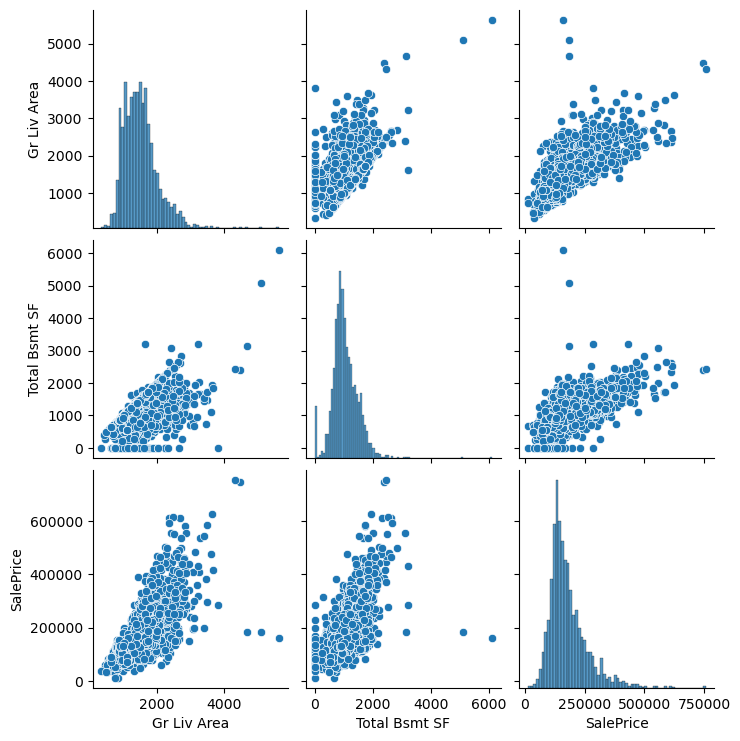

In [11]:
sns.pairplot(df[['Gr Liv Area', 'Total Bsmt SF', 'SalePrice']])
plt.show()

### Heatmap - Show correlation between numerical columns

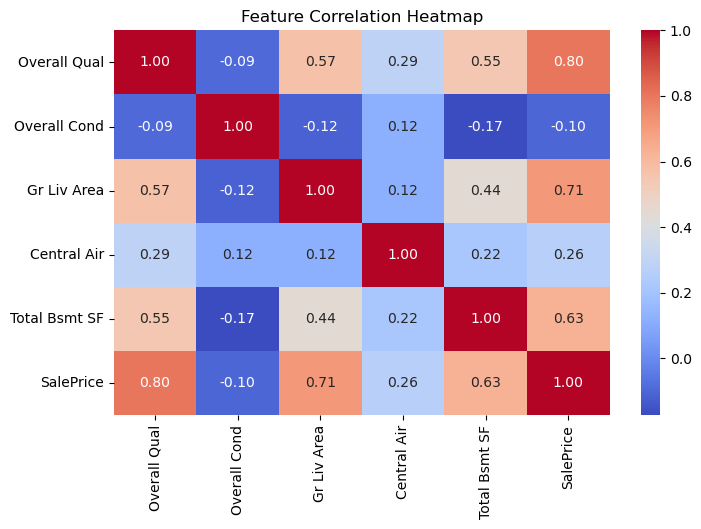

In [13]:
plt.figure(figsize=(8,5))
sns.heatmap(df[['Overall Qual', 'Overall Cond', 'Gr Liv Area',
           'Central Air', 'Total Bsmt SF', 'SalePrice']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

# Simple Linear Regresssion on Ames Dataset

Suppose we want to predict a house's Sale Price based on the size of its living area above ground in square feet (Gr Liv Area)

In [16]:
Y = df['SalePrice'].values
X = df[['Gr Liv Area']].values

## Divide the dataset into training and testing set

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Fit the linear regression model using the training set

In [20]:
lr = LinearRegressionGD(eta=0.01, n_epochs = 50, random_state=1)
lr = lr.fit(X_train, Y_train)

/var/folders/b4/bg8hklb13md1c25gf7g9xptr0000gr/T/ipykernel_78025/223089656.py:26: RuntimeWarning: overflow encountered in square
  self.costs_.append((errors**2).mean())


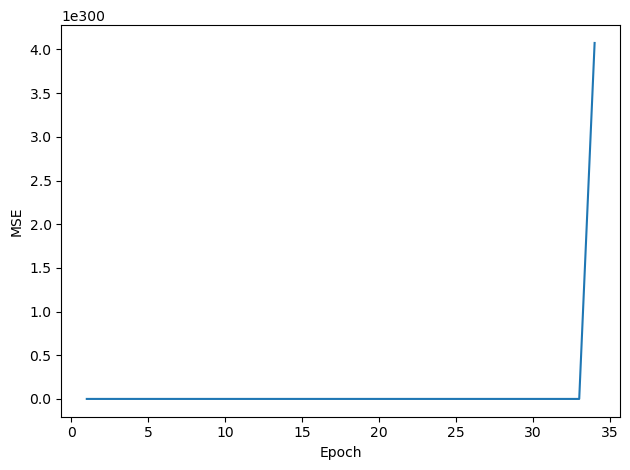

In [21]:
plt.plot(range(1, lr.n_epochs+1), lr.costs_)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.tight_layout()
#plt.savefig('figures/09_06.png', dpi=300)
plt.show()

Turned out, gradient descent algorithm does not do well when the feature and the target values have different scales


## Applying standard scalar on the dataset before using it to fit linear regression model

In [24]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
Y_std = sc_y.fit_transform(Y[:, np.newaxis]).flatten()

### Divide the standardized dataset into training and testing set

In [26]:
from sklearn.model_selection import train_test_split
X_train_std, X_test_std, Y_train_std, Y_test_std = train_test_split(X_std, Y_std, test_size=0.2, random_state=42)

In [27]:
lr = LinearRegressionGD(eta=0.01, n_epochs = 50, random_state=1)
lr = lr.fit(X_train_std, Y_train_std)

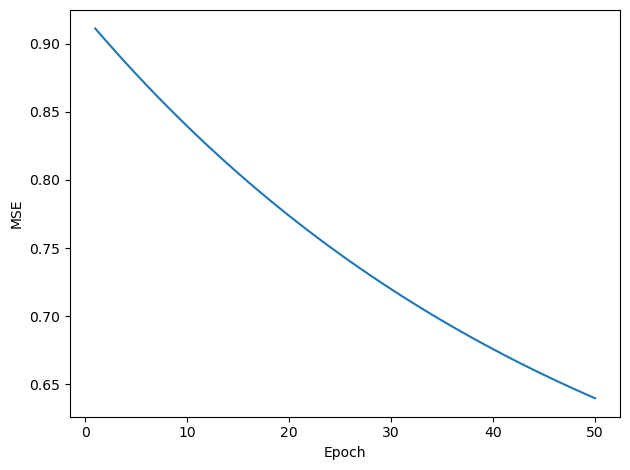

In [28]:
plt.plot(range(1, lr.n_epochs+1), lr.costs_)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

### Prediction on Standardized Testing Set

Since we train the model using standardized training set, it only makes sense to test it using standardized testing set,

In [31]:
Y_test_std_pred = lr.predict(X_test_std)

### Measuring the performance of the linear regression model

In [33]:
from sklearn.metrics import mean_squared_error
mse_test_std = mean_squared_error(Y_test_std, Y_test_std_pred)
print(f'MSE test standardized: {mse_test_std:.2f}')

MSE test standardized: 0.88


## Sale Price prediction on a house

Suppose we want to predict the SalePrice if the Gr.Liv Area is 1500 squared feet

In [36]:
feature_std = sc_x.transform(np.array([[1500]]))
target_std = lr.predict(feature_std)
target_reverted = sc_y.inverse_transform(target_std.reshape(-1, 1))
print(f'Predicted sale price is ${target_reverted.flatten()[0]:.2f} for Gr.Liv Area 1500')

Predicted sale price is $180005.50 for Gr.Liv Area 1500
